In [11]:
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np

# Load Data

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [7]:
X_coins = []
for line in open('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/coin_data.txt'):
    # 1 for H, 0 for T
    x = [1 if e == 'H' else 0 for e in line.rstrip()]
    X_coins.append(x)

print(X_coins[0])

[0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]


# HMM Model

In [8]:
class hmm_discrete:
    def __init__(self, m):
        self.M = m  # number of hidden states
        self.pi = None
        self.A = None
        self.B = None

    def fit(self, x, max_iter=30, initial_probs=None, random_state=123):
        # train the HMM model using the Baum-Welch algorithm (a kind of the expectation-maximization algorithm)
        t0 = datetime.now()

        # x is a collection of sequences with different lengths (its a jagged array of observed sequences)
        V = max(max(xi) for xi in x) + 1
        N = len(x)

        if initial_probs is not None:
            self.pi, self.A, self.B = initial_probs
        else:
            # initialize distributions randomly
            np.random.seed(random_state)
            self.pi = np.ones(self.M) / self.M
            self.A = self._random_normalized(self.M, self.M)
            self.B = self._random_normalized(self.M, V)
            print("initial pi:", self.pi)
            print("initial A:", self.A)
            print("initial B:", self.B)

        history = {'cost': []}
        for step in range(max_iter):
            if step % 10 == 0:
                print('step:', step)

            Px = np.zeros(N)

            # step 1 - E step (estimate alpha, beta that depends on pi, A and B)
            alphas = []
            betas = []
            for n in range(N):
                x_seq = x[n]
                T = len(x_seq)
                alpha = np.zeros((T, self.M))
                alpha[0, :] = self.pi * self.B[:, x_seq[0]]
                for t in range(1, T):
                    alpha[t, :] = self.B[:, x_seq[t]] * alpha[t - 1, :].dot(self.A)
                alphas.append(alpha)
                Px[n] = alpha[-1].sum()

                beta = np.zeros((T, self.M))
                beta[-1, :] = 1
                for t in range(T - 2, -1, -1):
                    beta[t, :] = self.A.dot(self.B[:, x_seq[t + 1]] * beta[t + 1, :])
                betas.append(beta)

            history['cost'].append(np.mean(np.log(Px)))

            # step 2 - M step (re-estimate pi, A, B that depends on alpha, beta)
            pi = np.zeros((N, self.M))
            A_num = np.zeros((N, self.M, self.M))
            A_denom = np.zeros((N, self.M, self.M))
            B_num = np.zeros((N, self.M, V))
            B_denom = np.zeros((N, self.M, V))
            for n in range(N):
                alpha = alphas[n]
                beta = betas[n]
                x_seq = x[n]
                T = len(x_seq)

                # re-estimate pi
                pi[n, :] = (alpha[0, :] * beta[0, :]) / Px[n]

                # re-estimate A
                a_num = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T - 1):
                            a_num[i, j] += alpha[t, i] * self.A[i, j] * self.B[j, x_seq[t + 1]] * beta[t + 1, j]
                A_num[n, :, :] = a_num / Px[n]
                A_denom[n, :, :] = (alpha[:-1] * beta[:-1]).sum(axis=0, keepdims=True).T / Px[n]

                # re-estimate B
                b_num = np.zeros((self.M, V))
                for i in range(self.M):
                    for t in range(T):
                        k = x_seq[t]
                        b_num[i, k] += alpha[t, i] * beta[t, i]
                B_num[n, :, :] = b_num / Px[n]
                B_denom[n, :, :] = (alpha * beta).sum(axis=0, keepdims=True).T / Px[n]

            self.pi = pi.mean(axis=0)
            self.A = A_num.sum(axis=0) / A_denom.sum(axis=0)
            self.B = B_num.sum(axis=0) / B_denom.sum(axis=0)

        print("Discrete HMM fit duration:", (datetime.now() - t0))
        return history

    def _random_normalized(self, d1, d2):
        x = np.random.random((d1, d2))
        return x / x.sum(axis=1, keepdims=True)

    def forward(self, x):
        # first part of the hmm forward-backward algorithm
        # x - observed sequence, z - is not observable hidden states sequence
        # returns probability of sequence under model parameters = likelihood of one sequence sequence observation

        alpha = self.pi * self.B[:, x[0]]
        for t in range(1, len(x)):
            alpha = self.B[:, x[t]] * alpha.dot(self.A)
        return np.sum(alpha)

    def sequence_likelihood(self, x):
        return [self.forward(xi) for xi in x]

    def sequence_log_likelihood(self, x):
        return np.log(self.sequence_likelihood(x))

    def likelihood(self, x):
        return self.forward(x)

    def log_likelihood(self, x):
        return np.log(self.likelihood(x))

    def fit_scaled(self, x, max_iter=30, initial_probs=None, random_state=123):
        # train the HMM model using the Baum-Welch algorithm (a kind of the expectation-maximization algorithm)
        # including stalling by c scaling factor
        t0 = datetime.now()

        # x is a collection of sequences with different lengths (its a jagged array of observed sequences)
        V = max(max(xi) for xi in x) + 1
        N = len(x)

        if initial_probs is not None:
            self.pi, self.A, self.B = initial_probs
        else:
            # initialize distributions randomly
            np.random.seed(random_state)
            self.pi = np.ones(self.M) / self.M
            self.A = self._random_normalized(self.M, self.M)
            self.B = self._random_normalized(self.M, V)
            print("initial pi:", self.pi)
            print("initial A:", self.A)
            print("initial B:", self.B)

        history = {'cost': []}
        for step in range(max_iter):
            if step % 10 == 0:
                print('step:', step)

            log_Px = np.zeros(N)

            # step 1 - E step (estimate alpha, beta that depends on pi, A and B)
            alphas = []
            betas = []
            scales = []
            for n in range(N):
                x_seq = x[n]
                T = len(x_seq)
                c = np.zeros(T)
                alpha_hat = np.zeros((T, self.M))

                # t = 0
                alpha_prim = self.pi * self.B[:, x_seq[0]]
                c[0] = alpha_prim.sum()
                alpha_hat[0, :] = alpha_prim / c[0]

                # 1 <= t <= T - 1
                for t in range(1, T):
                    alpha_prim = self.B[:, x_seq[t]] * alpha_hat[t - 1, :].dot(self.A)
                    c[t] = alpha_prim.sum(axis=0)
                    alpha_hat[t, :] = alpha_prim / c[t]
                alphas.append(alpha_hat)
                scales.append(c)
                log_Px[n] = np.log(c).sum()

                beta_hat = np.zeros((T, self.M))
                beta_hat[-1, :] = 1
                for t in range(T - 2, -1, -1):
                    beta_hat[t, :] = self.A.dot(self.B[:, x_seq[t + 1]] * beta_hat[t + 1, :]) / c[t + 1]
                betas.append(beta_hat)


            history['cost'].append(np.mean(log_Px))

            # step 2 - M step (re-estimate pi, A, B that depends on alpha, beta)
            pi = np.zeros((N, self.M))
            A_num = np.zeros((N, self.M, self.M))
            A_denom = np.zeros((N, self.M, self.M))
            B_num = np.zeros((N, self.M, V))
            B_denom = np.zeros((N, self.M, V))
            for n in range(N):
                alpha_hat = alphas[n]
                beta_hat = betas[n]
                c = scales[n]
                x_seq = x[n]
                T = len(x_seq)

                # re-estimate pi
                pi[n, :] = (alpha_hat[0, :] * beta_hat[0, :])

                # re-estimate A
                a_num = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T - 1):
                            a_num[i, j] += (alpha_hat[t, i] * beta_hat[t + 1, j]) / c[t + 1] * self.A[i, j] * self.B[j, x_seq[t + 1]]
                A_num[n, :, :] = a_num
                A_denom[n, :, :] = (alpha_hat[:-1] * beta_hat[:-1]).sum(axis=0, keepdims=True).T

                # re-estimate B
                b_num = np.zeros((self.M, V))
                for i in range(self.M):
                    for t in range(T):
                        k = x_seq[t]
                        b_num[i, k] += alpha_hat[t, i] * beta_hat[t, i]
                B_num[n, :, :] = b_num
                B_denom[n, :, :] = (alpha_hat * beta_hat).sum(axis=0, keepdims=True).T

            self.pi = pi.mean(axis=0)
            self.A = A_num.sum(axis=0) / A_denom.sum(axis=0)
            self.B = B_num.sum(axis=0) / B_denom.sum(axis=0)

        print("Discrete HMM fit duration:", (datetime.now() - t0))
        return history

    def forward_scaled(self, x):
        return self._forward_states_prob_scaled(x).sum()

    def log_forward_scaled(self, x):
        return np.log(self._forward_states_prob_scaled(x)).sum()

    def log_forward_scaled(self, x):
        # first part of the hmm forward-backward algorithm
        # x - observed sequence, z - is not observable hidden states sequence
        # returns log of the probability of sequence under model parameters = likelihood of one sequence sequence observation

        T = len(x)
        scale = np.zeros(T)
        alpha_prim = np.zeros((T, self.M))
        alpha_hat = np.zeros((T, self.M))
        alpha_prim[0, :] = self.pi * self.B[:, x[0]]
        scale[0] = alpha_prim[0, :].sum()
        alpha_hat[0, :] = alpha_prim[0, :] / scale[0]
        for t in range(1, T):
            alpha_prim[t, :] = self.B[:, x[t]] * alpha_hat[t - 1, :].dot(self.A)
            scale[t] = alpha_prim[t, :].sum()
            alpha_hat[t, :] = alpha_prim[t, :] / scale[t]
        return np.log(scale).sum()

    def sequence_log_likelihood_scaled(self, x):
        return [self.log_forward_scaled(xi) for xi in x]

    def log_likelihood_scaled(self, x):
        return self.log_forward_scaled(x)

    def get_veterbi_hidden_states_sequence(self, x):
        # implementation of Veterbi (forward-backward) algorithm to find the most probable sequence of hidden states
        # x - observed sequence, z - is not observable hidden states sequence

        T = len(x)
        delta = np.zeros((T, self.M))  # observable states sequence distribution
        psi = np.zeros((T, self.M), dtype=int)  # hidden states sequence distribution

        delta[0, :] = np.log(self.pi) + np.log(self.B[:, x[0]])

        for t in range(1, T):
            for j in range(self.M):
                optimal_transition_distribution = delta[t - 1, :] + np.log(self.A[:, j])
                delta[t, j] = np.max(optimal_transition_distribution) + np.log(self.B[j, x[t]])
                psi[t, j] = np.argmax(optimal_transition_distribution)

        # backtrack
        z = []  # estimation of most probable hidden states sequence (maximum likelihood estimator)
        z.append(np.argmax(delta[-1, :]))  # last step
        for t in range(T-1, 0, -1):
            z.append(psi[t, z[-1]])

        return z[::-1]


# Model test

In [12]:
def random_normalized(d1, d2):
    x = np.random.random((d1, d2))
    return x / x.sum(axis=1, keepdims=True)


def fit_coin_test(hmm_model, x, fit_method, probs_init):
    history = fit_method(x, initial_probs=probs_init)
    plt.plot(history['cost'])
    plt.show()

    print("fitted pi:", hmm_model.pi)
    print("fitted A:", hmm_model.A)
    print("fitted B:", hmm_model.B)

Random initial probabilities scenario

initial pi: [0.5 0.5]
initial A: [[0.49067536 0.50932464]
 [0.93346355 0.06653645]]
initial B: [[0.77853388 0.22146612]
 [0.058077   0.941923  ]] 

step: 0
step: 10
step: 20
Discrete HMM fit duration: 0:00:01.106365


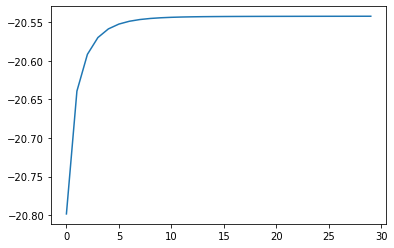

fitted pi: [0.67205401 0.32794599]
fitted A: [[0.58738833 0.41261167]
 [0.89060567 0.10939433]]
fitted B: [[0.73474222 0.26525778]
 [0.12149278 0.87850722]]
LL with fitted params: -1027.1214187270414 

step: 0
step: 10
step: 20
Discrete HMM fit duration: 0:00:00.966941


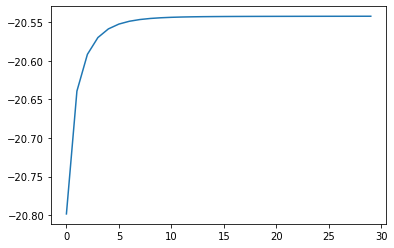

fitted pi: [0.67205401 0.32794599]
fitted A: [[0.58738833 0.41261167]
 [0.89060567 0.10939433]]
fitted B: [[0.73474222 0.26525778]
 [0.12149278 0.87850722]]
LL with fitted with scaling params: -1027.1214187270414 


true pi: [0.5 0.5]
true A: [[0.1 0.9]
 [0.8 0.2]]
true B: [[0.6 0.4]
 [0.3 0.7]]


In [13]:
M = 2  # number of hidden states
V = max(max(xi) for xi in X_coins) + 1  # number of observable states

# random initial probs
print('Random initial probabilities scenario')
PI = np.ones(M) / M
A = random_normalized(M, M)
B = random_normalized(M, V)
print("\ninitial pi:", PI)
print("initial A:", A)
print("initial B:", B, '\n')

hmm = hmm_discrete(M)
fit_coin_test(hmm, X_coins, hmm.fit, (PI.copy(), A.copy(), B.copy()))
L = np.sum(hmm.sequence_log_likelihood(X_coins))
print("LL with fitted params:", L, '\n')

hmm_scaled = hmm_discrete(M)
fit_coin_test(hmm_scaled, X_coins, hmm_scaled.fit_scaled, (PI.copy(), A.copy(), B.copy()))
L = np.sum(hmm_scaled.sequence_log_likelihood_scaled(X_coins))
print("LL with fitted with scaling params:", L, '\n')

# true variables
PI = np.array([0.5, 0.5])
A = np.array([[0.1, 0.9], [0.8, 0.2]])
B = np.array([[0.6, 0.4], [0.3, 0.7]])
print("\ntrue pi:", PI)
print("true A:", A)
print("true B:", B)
